In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

import ark.mibi.qc_comp as qc_comp
import ark.utils.io_utils as io_utils

### Define parameters

In [ ]:
# define paths to the data
base_dir = "../data/erin_data"
tiff_dir = base_dir

In [ ]:
# define if MIBItiff images are used or not
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

In [ ]:
# define the fovs used for analysis
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

In [ ]:
# define the channels used for analysis
# if None, uses all of the channels
chans = None

In [ ]:
# whether to add Gaussian blurring to the image before extracting QC metrics
gaussian_blur = False

# define the Gaussian blur sigma parameter, higher values are more aggressive removing noise
# ignored if gaussian_blur set to False
blur_factor = 1

### Create QC metric tables

In [ ]:
# note: set img_sub_folder to None if there aren't any
qc_data = qc_comp.compute_qc_metrics(
    tiff_dir,
    img_sub_folder=None,
    is_mibitiff=MIBItiff,
    fovs=fovs,
    chans=chans,
    batch_size=5,
    gaussian_blur=gaussian_blur,
    blur_factor=blur_factor
)

In [ ]:
df_nonzero_mean = qc_data['nonzero_mean']
df_total_intensity = qc_data['total_intensity']
df_99_9_intensity = qc_data['99_9_intensity']

In [ ]:
# extract just the number from the fov name (for sorting purposes)
# NOTE: this assumes that naming schemes follow MIBI standards (ex. Point{n} or fov{n})
df_nonzero_mean['fov'] = df_nonzero_mean.apply(lambda row: re.findall('(\d+)', row['fov'])[0], axis=1).astype(int)
df_total_intensity['fov'] = df_total_intensity.apply(lambda row: re.findall('(\d+)', row['fov'])[0], axis=1).astype(int)
df_99_9_intensity['fov'] = df_99_9_intensity.apply(lambda row: re.findall('(\d+)', row['fov'])[0], axis=1).astype(int)

In [ ]:
# sort the data by increasing fov number (for visualization)
df_nonzero_mean = df_nonzero_mean.sort_values(by='fov')
df_total_intensity = df_total_intensity.sort_values(by='fov')
df_99_9_intensity = df_99_9_intensity.sort_values(by='fov')

In [ ]:
# save the QC metric values
df_nonzero_mean.to_csv(os.path.join(base_dir, 'nonzero_mean_stats.csv'), index=False)
df_total_intensity.to_csv(os.path.join(base_dir, 'total_intensity_stats.csv'), index=False)
df_99_9_intensity.to_csv(os.path.join(base_dir, 'percentile_99_9_stats.csv'), index=False)

### Visualize QC metrics

In [ ]:
# melt the DataFrames for visualization
df_nonzero_mean_melt = pd.melt(df_nonzero_mean, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='Non-zero mean intensity')
df_total_intensity_melt = pd.melt(df_total_intensity, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='Total intensity')
df_99_9_intensity_melt = pd.melt(df_99_9_intensity, id_vars=['fov'], value_vars=chans, var_name='channel', value_name='99.9% intensity value')

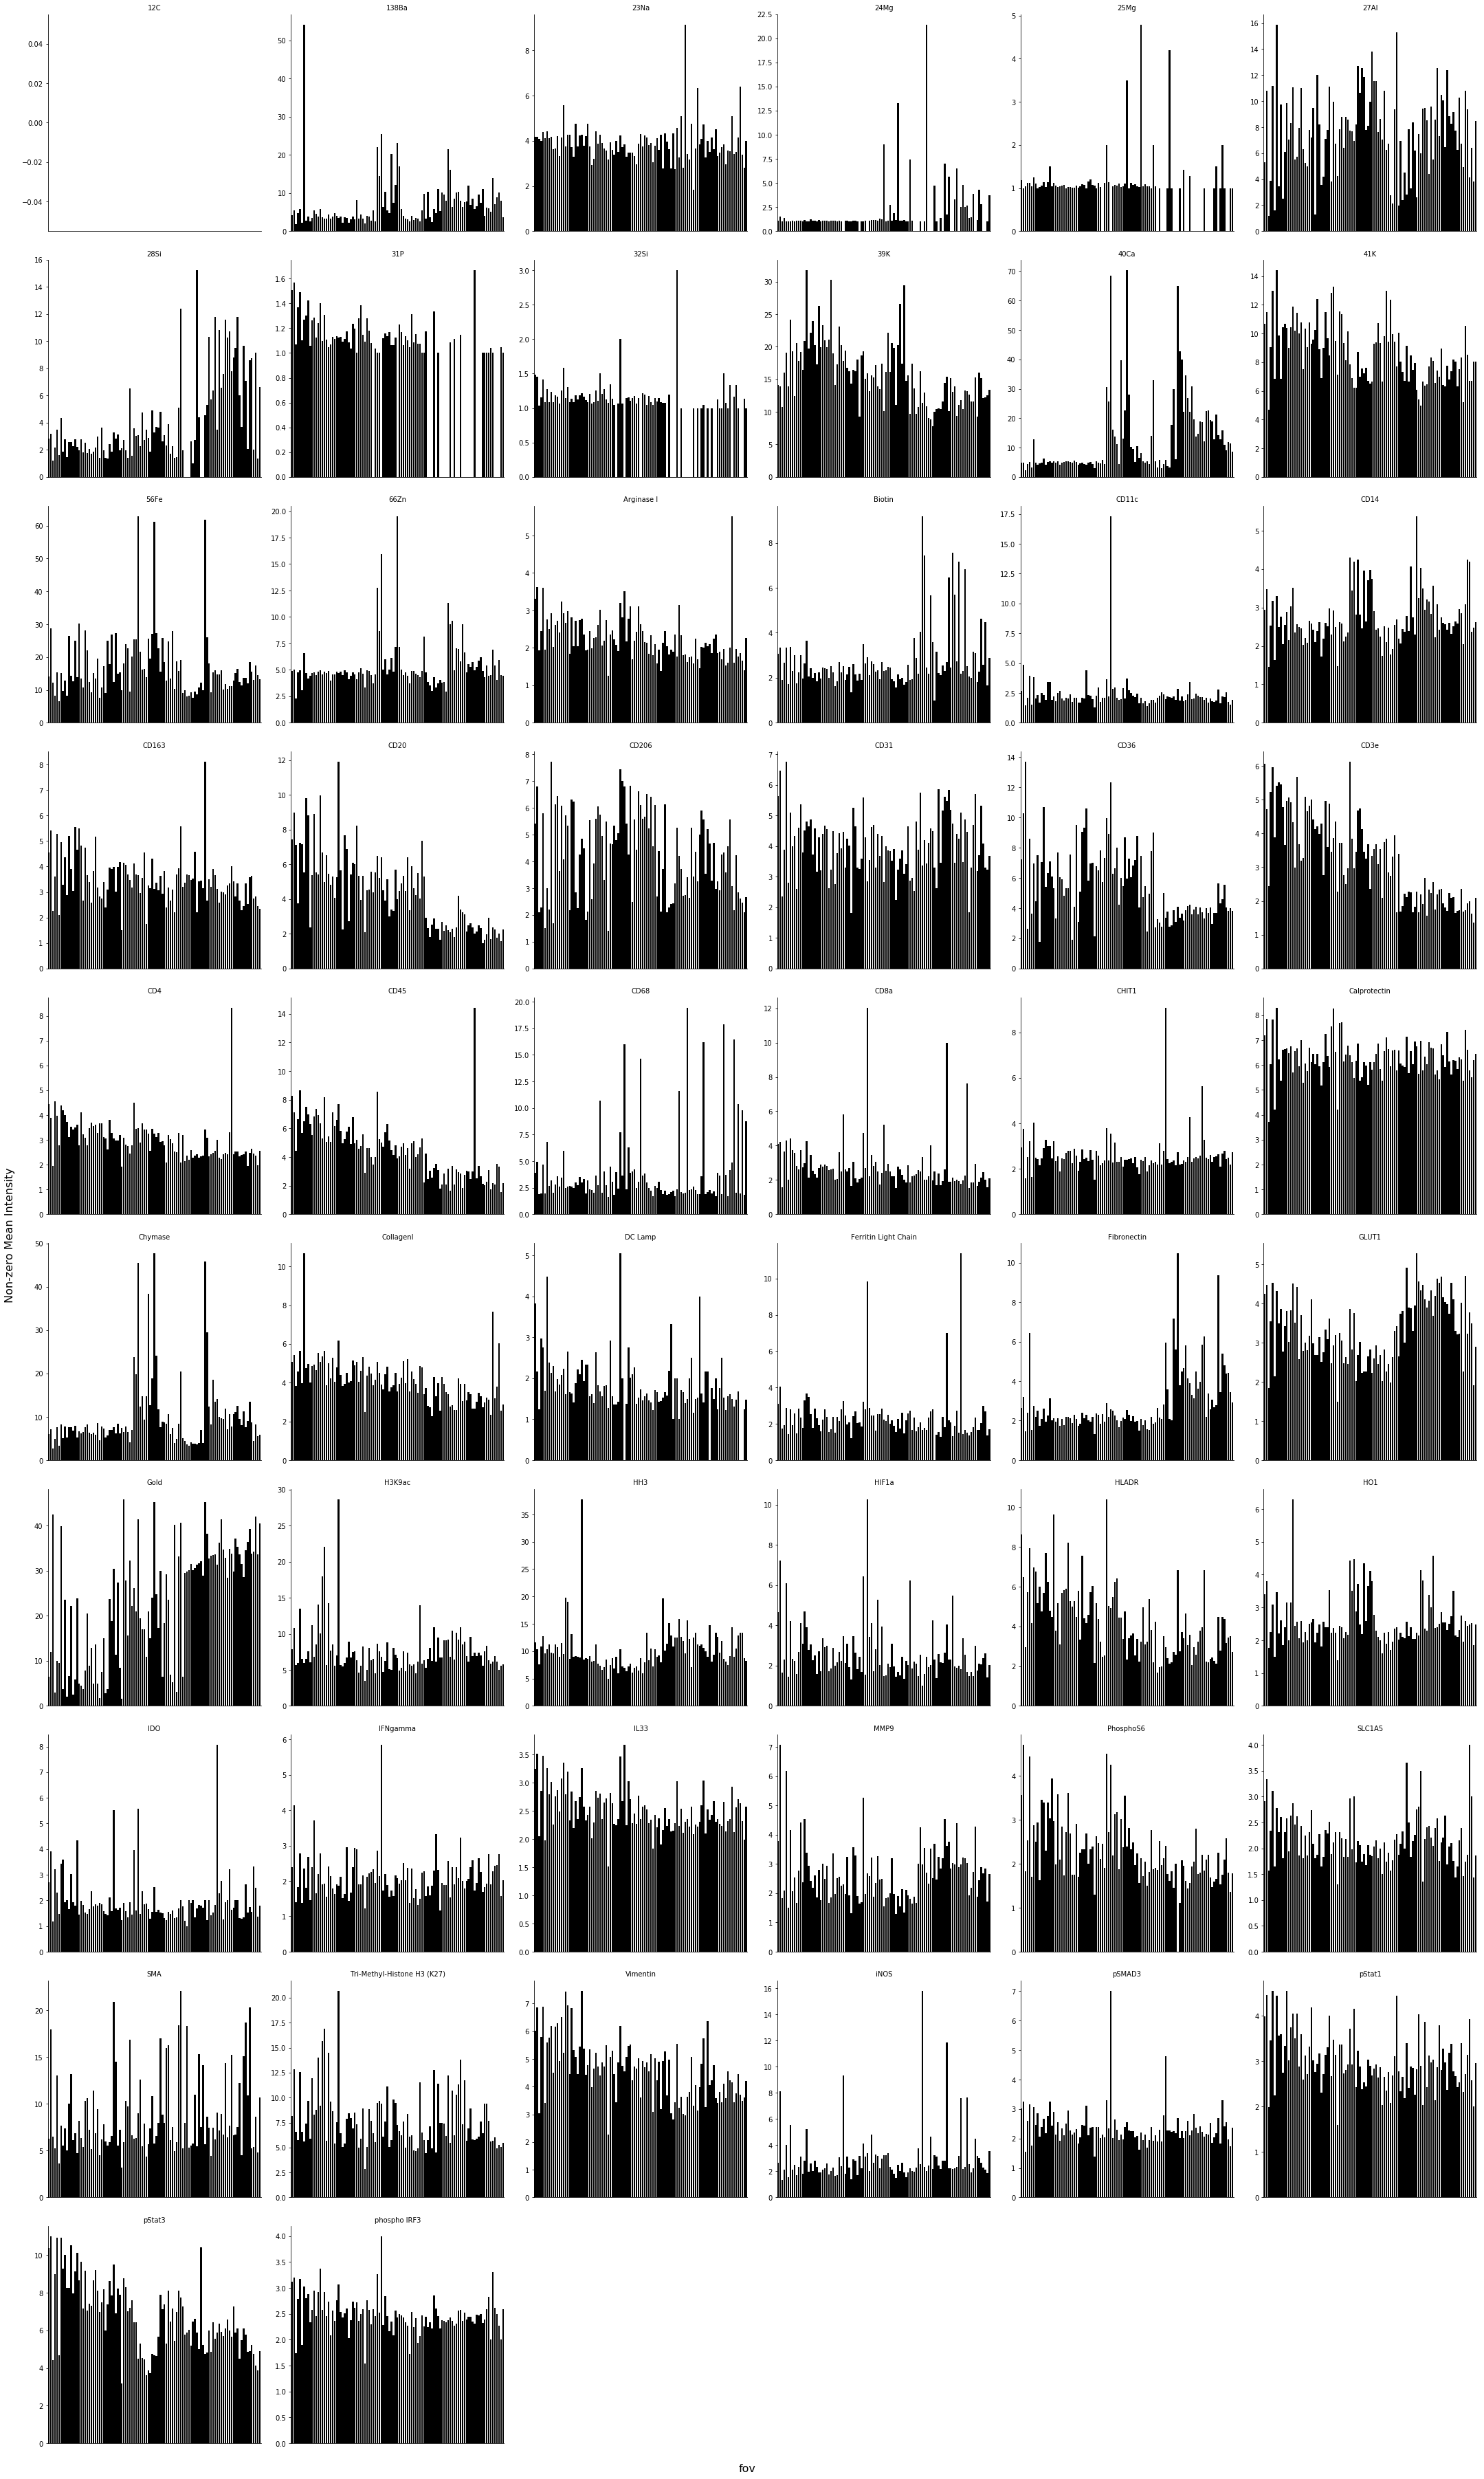

In [13]:
# visualize the non-zero mean intensity stats
qc_comp.visualize_qc_metrics(
    df_nonzero_mean_melt,
    'Non-zero mean intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

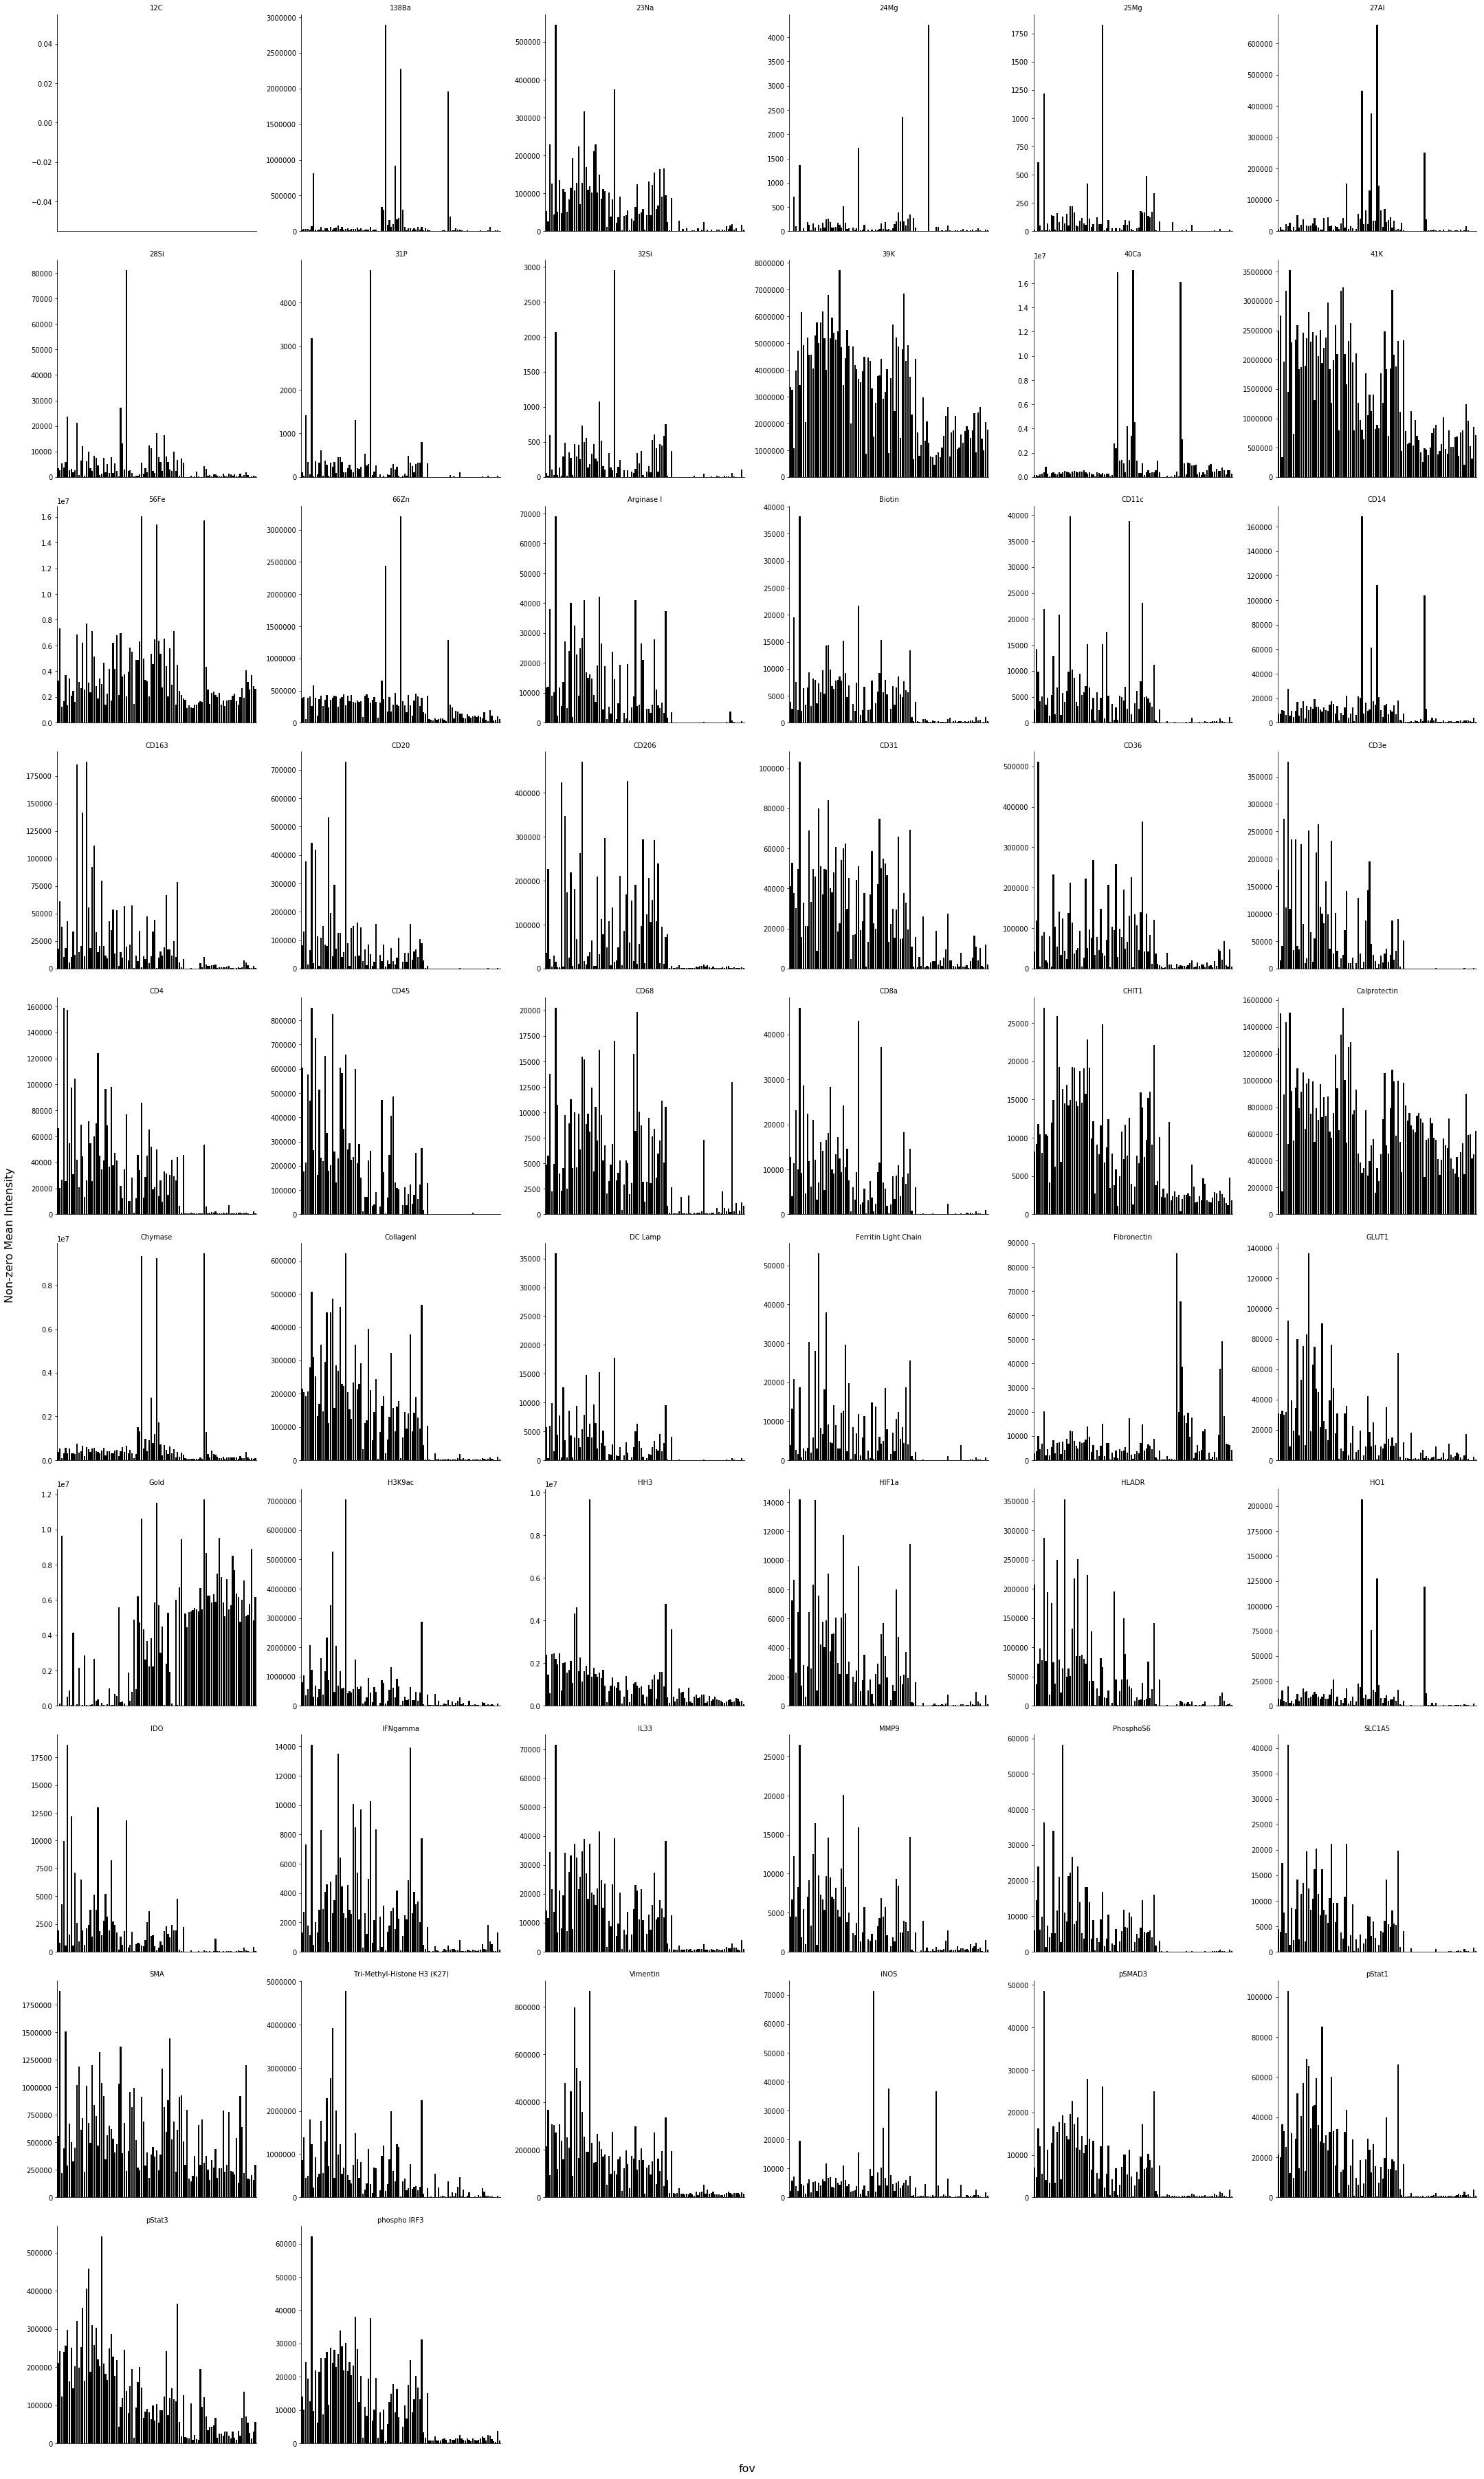

In [14]:
# visualize the total intensity stats
qc_comp.visualize_qc_metrics(
    df_total_intensity_melt,
    'Total intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

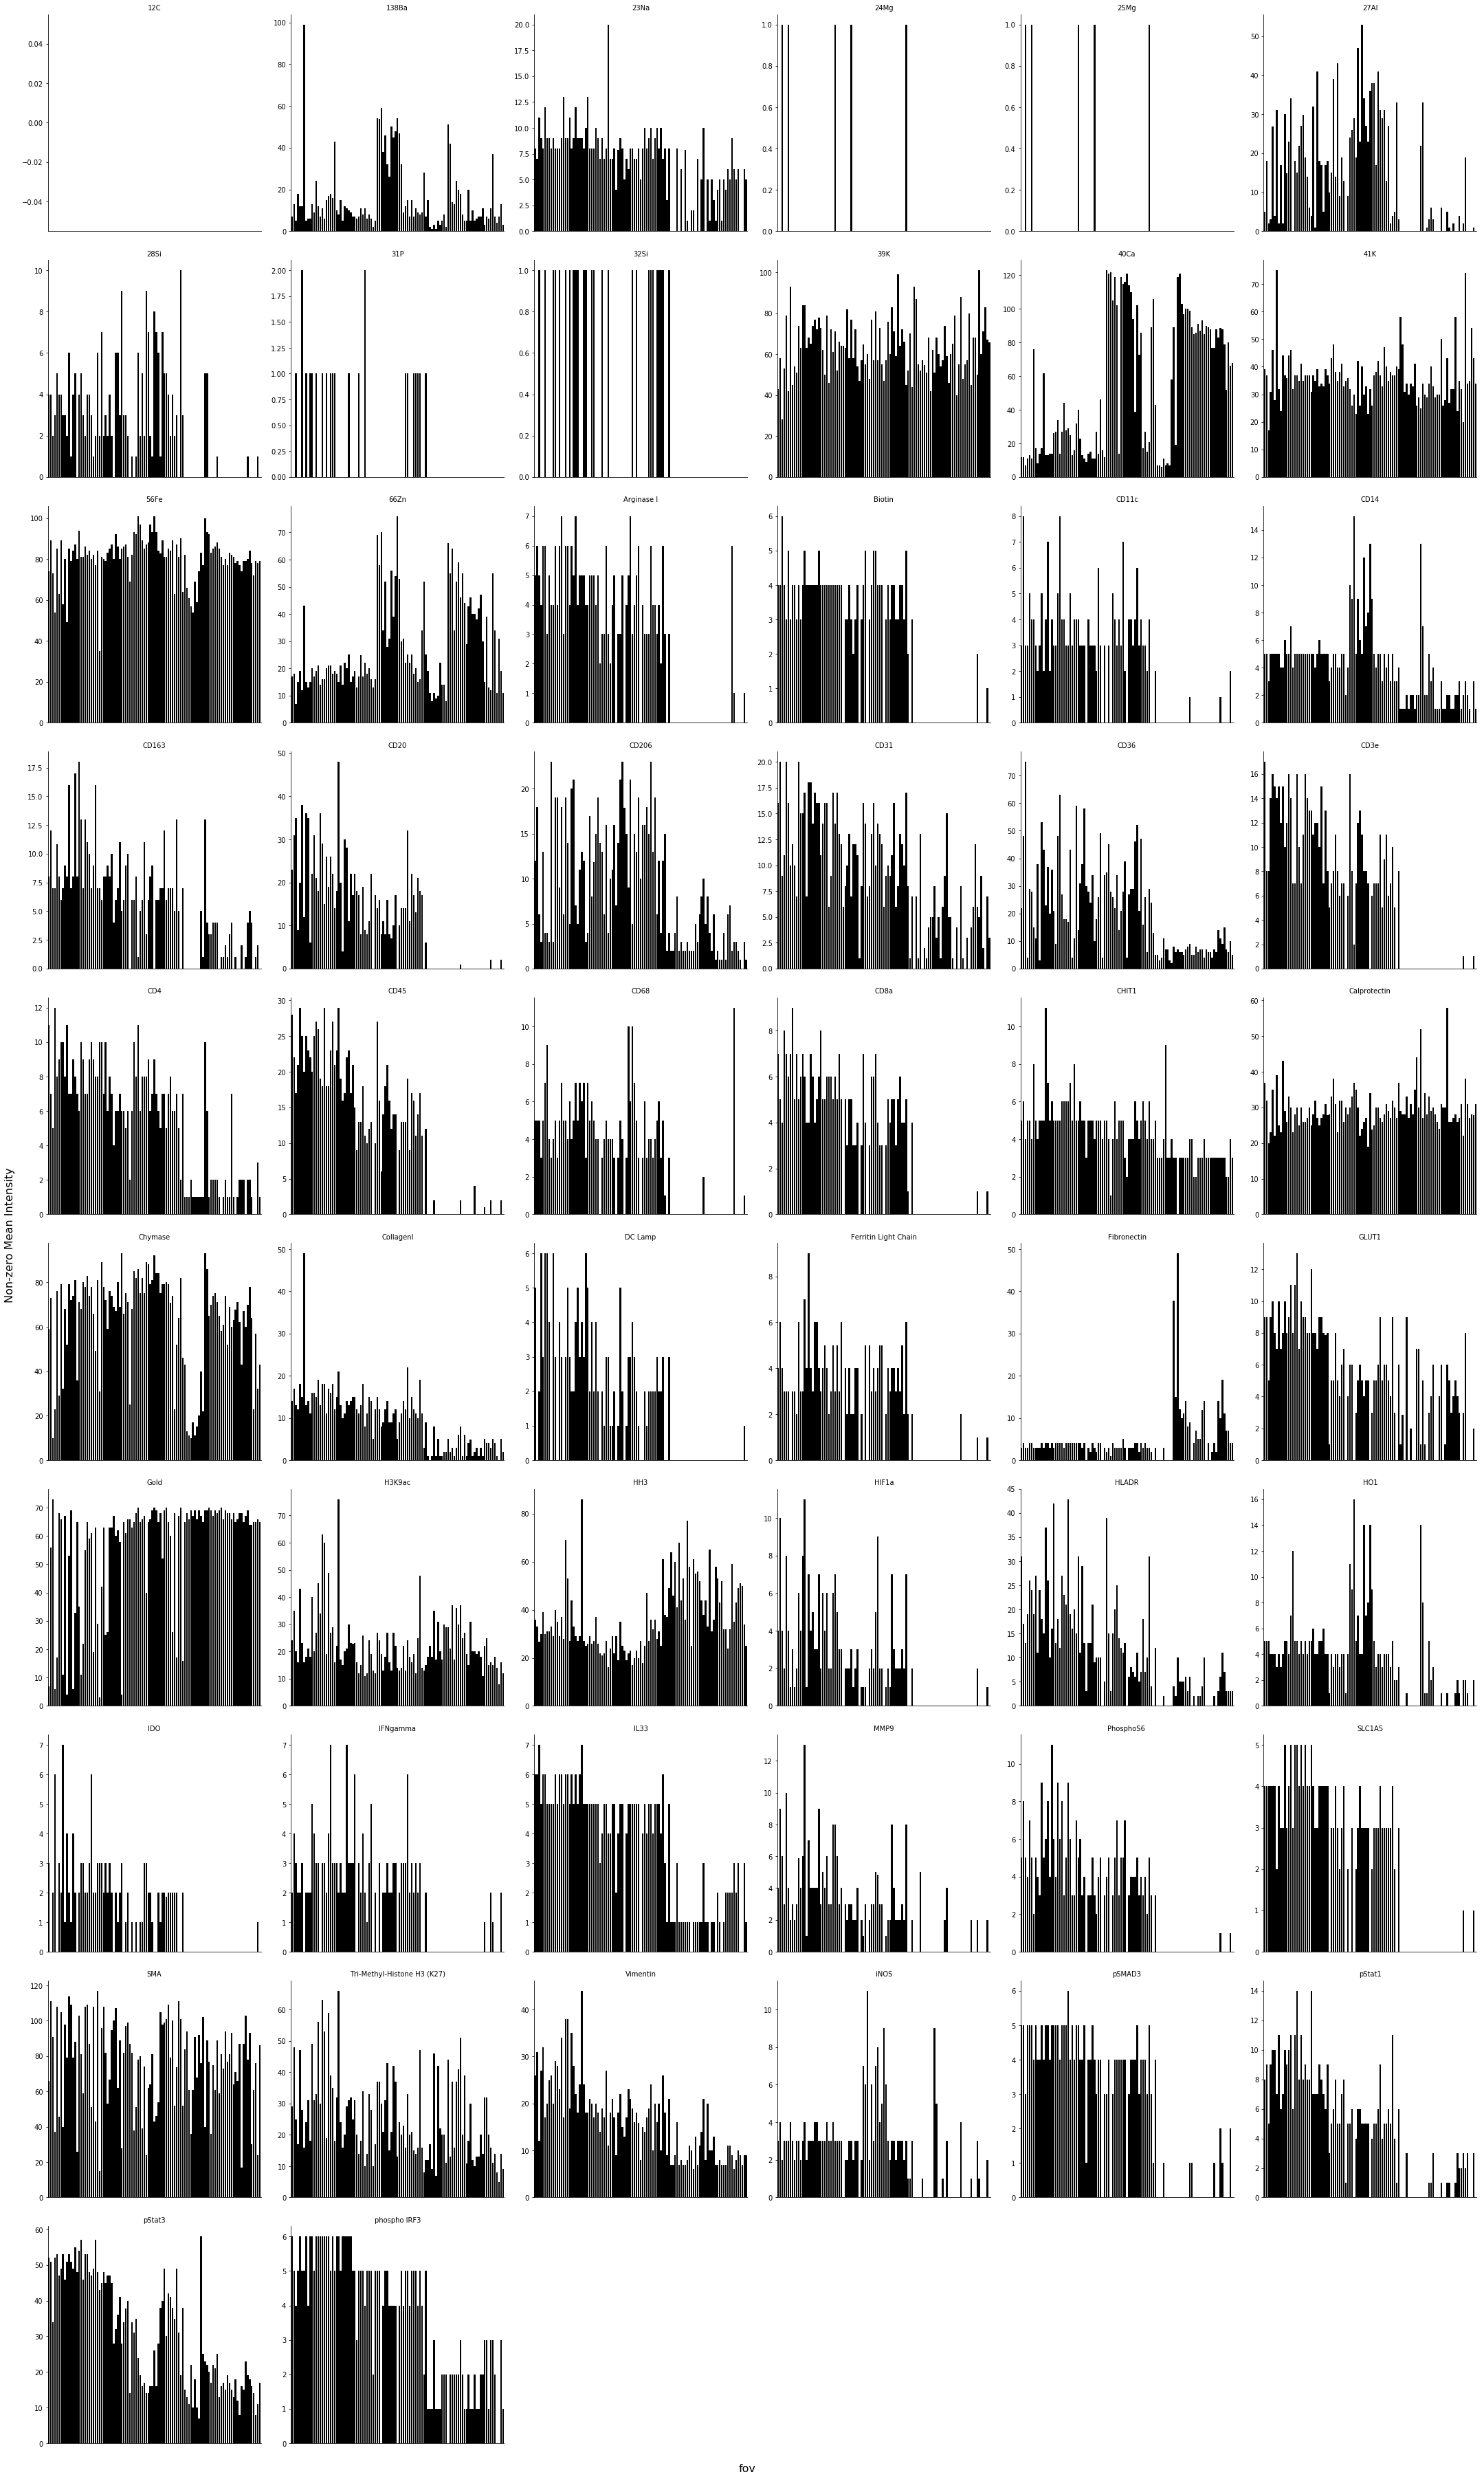

In [15]:
# visualize the 99.9% intensity value stats
qc_comp.visualize_qc_metrics(
    df_99_9_intensity_melt,
    '99.9% intensity value',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)